<a href="https://colab.research.google.com/github/karenalmeida18/recognize-notes-api/blob/main/squeezeNet_Cedulas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
learning_rate = 1e-3 # Taxa de aprendizado 0.0001
num_epochs = 40 # Numero de iterações
weight_decay = 6e-4 # (0.0008) Penalidade L2 -> Controla complexidade do modelo, quanto menor o valor, entao mais complexo é o modelo
len_batch = 32 # Tamanho do batch

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Bibliotecas necessárias
import torch
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score

# Verifica ambiente de execução
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device}")

# Caminho do dataset
IMAGES_ALL_DIR = '/content/drive/MyDrive/cedulas_dataset'
IMAGES_TRAIN_DIR = '/content/drive/MyDrive/cedulas_dataset/train'
IMAGES_TEST_DIR = '/content/drive/MyDrive/cedulas_dataset/test'
CEDULAS_DIR = '/content/drive/MyDrive/cedulas'

Rodando na cuda


In [ ]:
# exclui o diretorio de edição ipynb_checkpoints
class_list = list(filter(lambda f: not f.startswith(".ipynb_checkpoints"), os.listdir(IMAGES_TRAIN_DIR)))
print(class_list)

['nota-10', 'nota-2', 'nota-20', 'nota-200', 'nota-5', 'nota-50', 'nota-100']


In [ ]:
# Aumentar o dataset com diversas transformações -> ref: https://offsouza.medium.com/aumento-de-dados-artificialmente-python-e42dc49b085a
# https://github.com/aleju/imgaug#code_examples
import imgaug as ia
from PIL import Image
import cv2
import random
import numpy as np

apply_data_augmentation = ia.augmenters.Sequential(
[
    # combinação de escala. rotaçao, translaçao e cisalhamento
    ia.augmenters.Affine(
        # scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # porcentagem de transação
        rotate=(-45, 45), # porcentagem de rotaçao
        shear=(-16, 16), # intensidade do cisalhamento
        order=[0, 1], # ordem do polinomia usado para interpolaçao
        cval=(0, 255), # valor para preencher as areas apos transformação
        mode=ia.ALL
    ),
    ia.augmenters.LinearContrast((0.75, 1.25)), # Ajusta o constrate
    ia.augmenters.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # Aplcia ruido
    # ia.augmenters.Sometimes(0.5, ia.augmenters.Crop(percent=(0, 0.1))),
    ia.augmenters.Sometimes(0.5, ia.augmenters.PerspectiveTransform(scale=(0.01, 0.1))) # mudança perspectiva
],
random_order=True)

def save_nem_image(image, image_name, image_folder, transf, i, j):
  image_name_splited = os.path.splitext(image_name)
  image_name = image_name_splited[0];
  new_image_name = image_name + "-" + str(i) + '_' + str(j) + transf + ".jpeg"
  print(new_image_name)
  image.save(os.path.join(image_folder, new_image_name), format = "JPEG")

def increase_dataset(root_dir, classes):
  for class_name in classes:
    class_folder = os.path.join(root_dir, class_name)
    images_list = os.listdir(class_folder)
    for i, image_name in enumerate(images_list):
      if 'google' in image_name:
        print(image_name)
        for j in range(5):
          image = Image.open(os.path.join(root_dir, class_name, image_name))
          image_array = np.array(image)
          images_aug = apply_data_augmentation(images=[image_array])
          save_nem_image(Image.fromarray(images_aug[0]), image_name, class_folder, 'synthetic', i, j)

# RODAR APENAS UMA VEZ P AUMENTAR DADOS ORIGINAIS
# increase_dataset(IMAGES_TRAIN_DIR, class_list)

In [ ]:
# 3.1 Cria CSV e divide em teste e treino
import csv


def build_csv(root_dir, csv_name, classes):
    # Abre o arquivo csv para escrita a partir do caminho dado
    with open(csv_name, mode="w", newline="") as file:
      writer = csv.writer(file, delimiter=',')
      writer.writerow(['name', 'class_name'])
      # Percorre todos os arquivos de cada pasta (classe)
      for class_name in classes:
          current_class_path = os.path.join(root_dir, class_name)
          current_class_list = os.listdir(current_class_path)
          for image_name in current_class_list:
            if not image_name.startswith('.'):
              writer.writerow([image_name, class_name])

In [ ]:
from torch.utils.data import Dataset
import pandas as pd
import cv2
import numpy as np
from PIL import Image

## Classe dataset que herda de Data
class BanknotesDataset(Dataset):
  def __init__(self, csv, root_dir, transform=None):
    self.root_dir = root_dir
    self.csv_data = pd.read_csv(csv)
    self.transform = transform

  def __len__(self):
    return len(self.csv_data)

  def __getitem__(self, index):
    image_name = self.csv_data.iloc[index, 0]
    image_class = self.csv_data.iloc[index, 1]
    image_class_index = class_list.index(image_class)

    path = os.path.join(self.root_dir, image_class, image_name)
    image = Image.open(path)

    if self.transform:
      image = self.transform(image)

    return image, image_class_index

In [ ]:
import pandas as pd

def show_dataset_class_table(classlist, root_dir):
    df = pd.DataFrame(columns=["classe", "total"])
    for class_name in classlist:
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            count = len(images)
            df = df.append({"classe": class_name, "total": count}, ignore_index=True)
    return df

show_dataset_class_table(class_list, IMAGES_TRAIN_DIR)

<ipython-input-9-f4339721f5b9>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"classe": class_name, "total": count}, ignore_index=True)
<ipython-input-9-f4339721f5b9>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"classe": class_name, "total": count}, ignore_index=True)
<ipython-input-9-f4339721f5b9>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"classe": class_name, "total": count}, ignore_index=True)
<ipython-input-9-f4339721f5b9>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"classe": class_name, "total": count}, ignore_index=True)
<ipython-input-9-f433972

,classe,total
0,nota-10,1160
1,nota-2,1024
2,nota-20,877
3,nota-200,548
4,nota-5,967
5,nota-50,1026
6,nota-100,895


In [ ]:
# Modelo pretreinado - VGG16
from torchvision import datasets, models, transforms
from torch import optim, nn

# Carrega o modelo pretreinado - sequeezenet
model = models.squeezenet1_1(pretrained=True).to(device)
# Fine tunning - Subtitui a camada de classificação (última)
model.classifier[1] = nn.Conv2d(512, len(class_list), kernel_size=(1, 1)).to(device)
print(model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 25.8MB/s]


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [ ]:
# Definindo múltiplos hiperparametros (menor pras outras camadas)
optimizer = optim.Adam([
    { 'params': model.features.parameters(), 'lr': learning_rate * 0.2, 'weight_decay': weight_decay * 0.2 },
    { 'params': model.classifier.parameters(), 'lr': learning_rate, 'weight_decay': weight_decay },
], lr = 0)

# Função de perda -> entropia cruzada
lossfunc = nn.CrossEntropyLoss().to(device)

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

# Transformações a serem aplicadas de acordo com o modelo pretreinado do ImageNet
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

build_csv(IMAGES_TRAIN_DIR, 'train.csv', class_list)
build_csv(IMAGES_TEST_DIR, 'test.csv', class_list)

train_dataset = BanknotesDataset('train.csv', IMAGES_TRAIN_DIR, train_transform)
test_dataset = BanknotesDataset('test.csv', IMAGES_TEST_DIR, train_transform)
print(len(train_dataset))
print(len(test_dataset))

train_loader = DataLoader(dataset=train_dataset, batch_size=len_batch, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=len_batch, shuffle=True)

6497
273


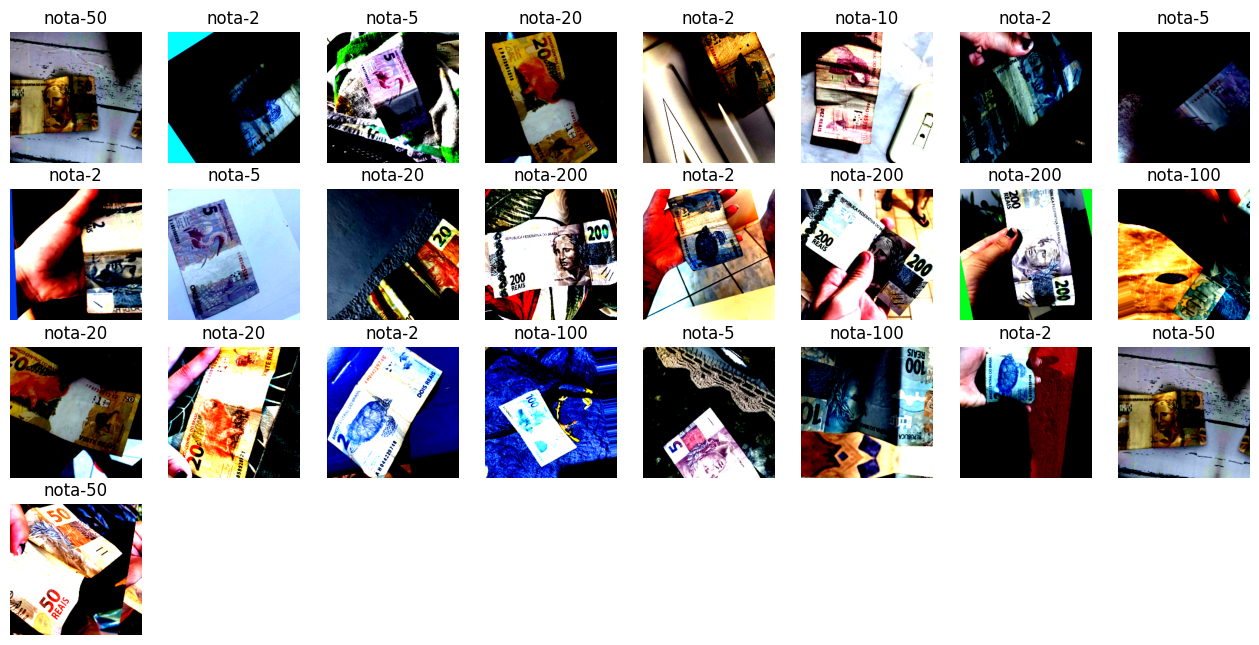

In [ ]:
def show_dataset_images(dataset, istensor=False):
  # projeta figura com 2 linha e 2 colunas
  plt.figure(figsize=(16, 16))
  for i in range(25):
      # amostra aleatoria de imagens
      index_sample = torch.randint(len(dataset), size=(1,)).item()
      # pega imagem e label da imagem
      img, idx = dataset[index_sample]
      # add na figura
      plt.subplot(8, 8, i+1)
      # adiciona o titulo pela categoria
      plt.title(class_list[idx])
      #
      plt.axis("off")
      # se for tensor precisa fazer uma permutação
      plt.imshow(img.squeeze().permute(1, 2, 0))
  plt.show()

show_dataset_images(train_dataset)

In [ ]:
import sklearn.metrics as metrics

# Função para treinar
def train(model_cnn, dataloader, lossfunc, optimizer, epoch):
  # treina o modelo
  model_cnn.train()
  cumloss = 0.0
  pred_labels, true_labels = [], []
  # para cada dado no dataloeder (img) e resultado (label)
  for img, label in dataloader:
    # aplica ao device atual
    img = img.to(device)
    label = label.to(device)

    # 1. Forward
    pred = model_cnn(img) # Alimentar os dados para a rede
    loss = lossfunc(pred, label) # Calcula a perda

    # 2. Backpropagation
    optimizer.zero_grad() # Zera os gradientes pra nao acumular
    loss.backward() # Caclular o gradiente
    optimizer.step() # Atualiza os pesos (Anda para frente)

    # Medidas para acuracia
    _, predicted = torch.max(pred.data, 1)

    # Adiciona os rótulos verdadeiros e previstos às listas
    true_labels.extend(label.cpu().numpy())
    pred_labels.extend(predicted.cpu().numpy())

    # loss é um tensor
    cumloss += loss.item()

  accuracy = metrics.accuracy_score(true_labels, pred_labels)
  acc_loss = cumloss / len(dataloader)
  return acc_loss, accuracy*100

In [ ]:
# Função para testar - mesma coisa, sem o backward
def test(model_cnn, dataloader, lossfunc, epoch):
  # avalia o modelo
  model_cnn.eval()
  cumloss = 0.0
  true_labels, pred_labels = [], []
  # para cada dado no dataloeder (img) e resultado (label)
  with torch.no_grad():
    for img, label in dataloader:
      # Alimenta rede (forward)
      img = img.to(device)
      label = label.to(device)
      pred = model_cnn(img)
      # Calcular função de perda
      loss = lossfunc(pred, label)
      # Medidas para acuracia
      _, predicted = torch.max(pred.data, 1)

      # Adiciona os rótulos verdadeiros e previstos às listas
      true_labels.extend(label.cpu().numpy())
      pred_labels.extend(predicted.cpu().numpy())
      cumloss += loss.item()


  accuracy = metrics.accuracy_score(true_labels, pred_labels)
  acc_loss = cumloss / len(dataloader)
  return acc_loss, accuracy*100, true_labels, pred_labels

In [ ]:
train_losses = []
test_losses = []

# Treina o modelo por cada epoca
for curr_epoch in range(num_epochs):
  train_loss, train_acc = train(model, train_loader, lossfunc, optimizer, curr_epoch)
  train_losses.append(train_loss)

  test_loss, test_acc, true_labels, pred_labels = test(model, test_loader, lossfunc, curr_epoch)
  test_losses.append(test_loss)

  print(f"Epoch: {curr_epoch}; Train Loss: {train_loss}; Test Loss: {test_loss};")
  print(f"Epoch: {curr_epoch}; Train Acc: {train_acc}; Test Acc: {test_acc};")

Epoch: 0; Train Loss: 0.26549978130531277; Test Loss: 0.13187752043207487;
Epoch: 0; Train Acc: 91.42681237494227; Test Acc: 94.87179487179486;
Epoch: 1; Train Loss: 0.09425212737964923; Test Loss: 0.10987135229839219;
Epoch: 1; Train Acc: 96.81391411420655; Test Acc: 96.7032967032967;
Epoch: 2; Train Loss: 0.06271628222049341; Test Loss: 0.16564124243126976;
Epoch: 2; Train Acc: 97.92211790056949; Test Acc: 93.4065934065934;
Epoch: 3; Train Loss: 0.07199064147130675; Test Loss: 0.13575284203721416;
Epoch: 3; Train Acc: 97.72202555025396; Test Acc: 97.43589743589743;
Epoch: 4; Train Loss: 0.039229149612176835; Test Loss: 0.14007646212768224;
Epoch: 4; Train Acc: 98.76866245959674; Test Acc: 95.23809523809523;
Epoch: 5; Train Loss: 0.0353546443154354; Test Loss: 0.038351459062444825;
Epoch: 5; Train Acc: 98.78405417885178; Test Acc: 98.9010989010989;
Epoch: 6; Train Loss: 0.011930899082837605; Test Loss: 0.04388053842315761;
Epoch: 6; Train Acc: 99.6613821763891; Test Acc: 99.2673992673

KeyboardInterrupt: ignored

<Axes: >

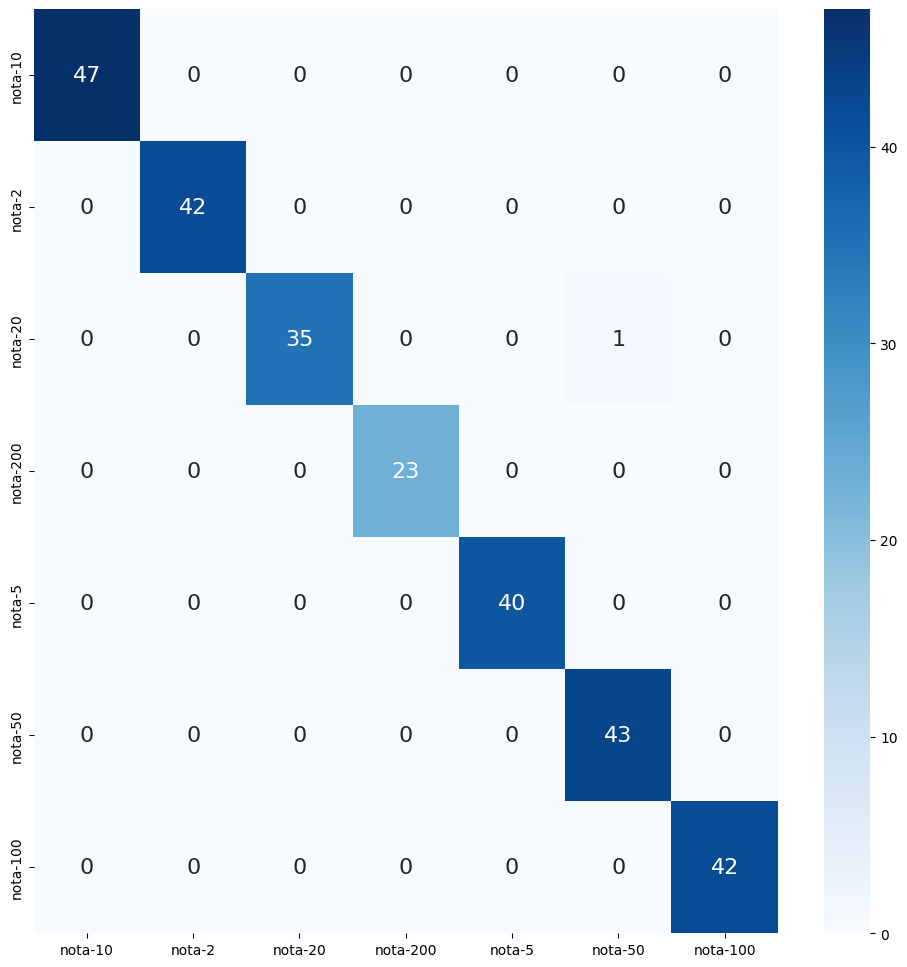

In [ ]:
import seaborn as sn

conf_matrix = metrics.confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(12, 12))
sn.heatmap(conf_matrix.tolist(), annot=True, cmap='Blues', annot_kws={"size": 16}, fmt='d',xticklabels=class_list, yticklabels=class_list)

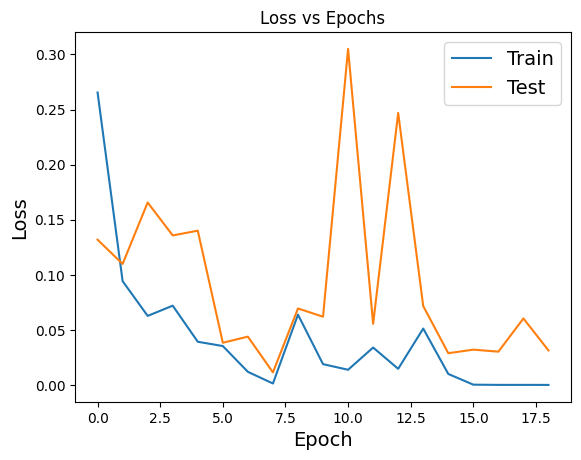

In [ ]:
# REf: https://youtu.be/iSpi3rKdoLQ
def plot_losses(losses):
  fig = plt.figure()
  ax = fig.gca()
  for loss_name, loss_values in losses.items():
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="14")
  ax.set_xlabel("Epoch", fontsize="14")
  ax.set_ylabel("Loss", fontsize="14")
  ax.set_title("Loss vs Epochs", fontsize="12");

losses = {"Train": train_losses, "Test": test_losses}
plot_losses(losses)

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/models/squeezeNet-32.pt')